## Import Packages

In [1]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools

import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.gnn_models import GCNModel as Model

## Curate Dataset

In [2]:
infile = "../data/combined_training_datasets_unique.sdf"
name = os.path.splitext(os.path.basename(infile))[0]

all_df = PandasTools.LoadSDF(infile)
all_df.head()

[20:35:54] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x7f03a0171b60>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x7f028d153d80>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x7f028d153df0>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x7f028d153e60>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x7f028d153ed0>


In [3]:
TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.OTHER,
    ]
TYPE2DCT = {t: (np.eye(len(TYPES))[idx]).tolist() for idx, t in enumerate(TYPES)}

ATOMS = ['C', 'O', 'S', 'N', 'P', 'H', 'F', 'Cl', 'Br', 'I', 'UNK']
ATOM2DCT = {ele: (np.eye(len(ATOMS))[idx]).tolist() for idx, ele in enumerate(ATOMS)}
HYBRIDS = [Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
    'UNK']
HYBRID2DCT = {ele: (np.eye(len(HYBRIDS))[idx]).tolist() for idx, ele in enumerate(HYBRIDS)}

def featurize(mol, readout):
    x = []
    # preprocess
    Chem.Kekulize(mol)
    AllChem.ComputeGasteigerCharges(mol)
    Chem.AssignStereochemistry(mol)
    # embed molecule
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    pos = mol.GetConformer().GetPositions()
    mol = Chem.RemoveHs(mol)
    # calculate node features
    ring = mol.GetRingInfo()
    for idx in range(mol.GetNumAtoms()):
        emd = []
        at = mol.GetAtomWithIdx(idx)
        ele = at.GetSymbol()
        ele = ele if ele in ATOMS else 'UNK'
        emd += ATOM2DCT[ele]
        emd += [at.GetDegree()]
        hyb = at.GetHybridization()
        hyb = hyb if hyb in HYBRIDS else "UNK"
        emd += HYBRID2DCT[hyb]
        emd += [at.GetImplicitValence()]
        emd += [at.GetIsAromatic()]
        emd += [ring.IsAtomInRingOfSize(idx, 3),
              ring.IsAtomInRingOfSize(idx, 4),
              ring.IsAtomInRingOfSize(idx, 5),
              ring.IsAtomInRingOfSize(idx, 6),
              ring.IsAtomInRingOfSize(idx, 7),
              ring.IsAtomInRingOfSize(idx, 8)]
        emd += [at.GetFormalCharge()]
        x.append(emd)
    x = torch.from_numpy(np.array(x))
    pos = torch.from_numpy(np.array(pos))
    # calculate edges/edge features
    bonds = []
    types = []
    for bond in mol.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()
        t = bond.GetBondType()
        t = t if t in TYPES else Chem.rdchem.BondType.OTHER
        bonds.append([idx1, idx2])
        types.append(TYPE2DCT[t])
        bonds.append([idx2, idx1])
        types.append(TYPE2DCT[t])
    # create graph
    edge_index = torch.from_numpy(np.array(bonds)).long()
    edge_type = torch.from_numpy(np.array(types)).long()
    data = Data(x=x, pos=pos, \
        edge_index=edge_index.t().contiguous(), edge_type=edge_type, 
        y=torch.from_numpy(np.array([readout])))
    return data

In [4]:
infile = "../data/combined_training_datasets_unique_graph_training.pkl"
if not os.path.exists(infile):
    # data preprocessing is time-consuming
    # some molecules would fail to featurize
    graph_data = []
    for idx, row in all_df.iterrows():
        try:
            mol = row["ROMol"]
            pka = float(row["pKa"])
            data = featurize(mol, pka)
            graph_data.append(data)
        except Exception as e:
            print(e)
    with open(infile, "wb") as file:
        pickle.dump(graph_data, file)

## Hyperparameters

In [5]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
ratio = 0.1
batch_size = 256
infile = "../data/combined_training_datasets_unique_graph_training.pkl"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Split dataset

In [6]:
if not os.path.exists(infile):
    # data preprocessing is time-consuming
    # some molecules would fail to featurize
    graph_data = []
    for idx, row in all_df.iterrows():
        try:
            mol = row["ROMol"]
            pka = float(row["pKa"])
            data = featurize(mol, pka)
            graph_data.append(data)
        except Exception as e:
            print(e)
    with open(infile, "wb") as file:
        pickle.dump(graph_data, file)


with open(infile, "rb") as file:
    graph_data = pickle.load(file)

num_relations = len(TYPES)
nsamples = len(graph_data)
val_size = int(nsamples*ratio)
val_indices = np.random.choice(nsamples, val_size, replace=False)
train_indices = set(range(nsamples)) - set(val_indices.tolist())
train_indices = list(train_indices)
train_data = [graph_data[idx] for idx in train_indices]
test_data = [graph_data[idx] for idx in val_indices]


d = train_data[0]
ndim = d.x.shape[1]
print(f"Dimension of node feature: {ndim}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

/home/mxue33/anaconda3/envs/sphinx/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Dimension of node feature: 27
Number of training samples: 5386
Number of validation samples: 598


## Model


References:
- [Explainable Graph Neural Networks with Data Augmentation for Predicting pKa of C–H Acids](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00958)
- [MolGpka: A Web Server for Small Molecule pKa Prediction Using a Graph-Convolutional Neural Network](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00075)
- [SchNet](https://arxiv.org/pdf/1706.08566) will be updated in the future to include molecular geometry

In [7]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for data in dataloader:
            optimizer.zero_grad()
            y_pred = model(data.to(device))
            y = data.y.to(device)
            loss = loss_func(y_pred.reshape(-1).float(), y.reshape(-1).float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data in dataloader:
            y_pred = model(data.to(device))
            y = data.y.to(device)
            loss = loss_func(y_pred.reshape(-1).float(), y.reshape(-1).float())
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [8]:
epochs = 500
lr = 5e-3
dtype = "float"

model = Model(ndim=27, hidden_dims=[256, 128, 64, 32], type=dtype)
model.to(device)
model = model.float() if dtype == "float" else model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

50487


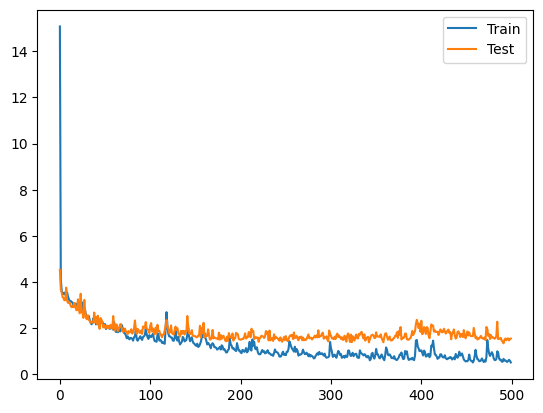

In [9]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(1.4559)


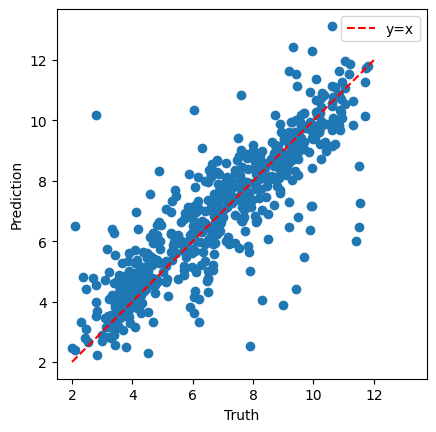

In [10]:
model.eval()

truth = []
pred = []
with torch.no_grad():
    for data in test_loader:
        y_pred = model(data.to(device))
        y = data.y
        truth.extend(y.numpy().tolist())
        pred.extend(y_pred.detach().numpy().tolist())
loss = loss_func(torch.Tensor(pred).reshape(-1), torch.Tensor(truth).reshape(-1))
print(loss)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()